# Praktyczne zastosowanie modeli oceny wartości relacji z klientem w czasie.

### Wczytanie bibliotek

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import plotly.graph_objs as go
from scipy.spatial import ConvexHull
from scipy.stats import zscore
from plotly.offline import init_notebook_mode,iplot
import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import warnings


### Konfiguracja

In [2]:
days_pl = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Niedziela']
months_pl = ['Styczeń', 'Luty', 'Marzec', 'Kwiecień', 'Maj', 'Czerwiec', 'Lipiec', 'Sierpień', 'Wrzesień', 'Październik', 'Listopad', 'Grudzień']
colors = ['#DF2020', '#81DF20', '#2095DF', '#c45200', '#00fff2', '#6f00ff', '#FFB400', '#0D2C54', '#50514F', '#321325', '#9D75CB', '#E6AACE' ] # Kolory dla maks. 6 kategorii

init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

### Wczytanie danych

In [3]:
df = pd.read_csv("./data/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


### Analiza eksploracyjna danych

***InvoiceNo***: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>
***StockCode***: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
***Description***: Product (item) name. Nominal. <br>
***Quantity***: The quantities of each product (item) per transaction. Numeric. <br>
***InvoiceDate***: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
***UnitPrice***: Unit price. Numeric, Product price per unit in sterling. <br>
***CustomerID***: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
***Country***: Country name. Nominal, the name of the country where each customer resides.

In [4]:
print(f'Liczba wierszy: {df.shape[0]} \nLiczba kolumn: {df.shape[1]}')

Liczba wierszy: 541909 
Liczba kolumn: 8


In [5]:
def summarizeDataframe( dataframe ):
    tab_info=pd.DataFrame(dataframe.dtypes).T.rename(index={0:'Column Type'})
    tab_info=tab_info.append(pd.DataFrame(dataframe.isnull().sum()).T.rename(index={0:'Missing values count'}))
    tab_info=tab_info.append(pd.DataFrame(dataframe.isnull().sum()/dataframe.shape[0]*100).T.
                            rename(index={0:'Percent of missing values'}))
    display(tab_info)

In [6]:
summarizeDataframe(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column Type,object,object,object,int64,object,float64,object,object
Missing values count,0,0,1454,0,0,0,135080,0
Percent of missing values,0,0,0.268311,0,0,0,24.9267,0


In [7]:
# Usunięcie obserwacji z brakującym "CustomerID"

df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
summarizeDataframe(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column Type,object,object,object,int64,object,float64,object,object
Missing values count,0,0,0,0,0,0,0,0
Percent of missing values,0,0,0,0,0,0,0,0


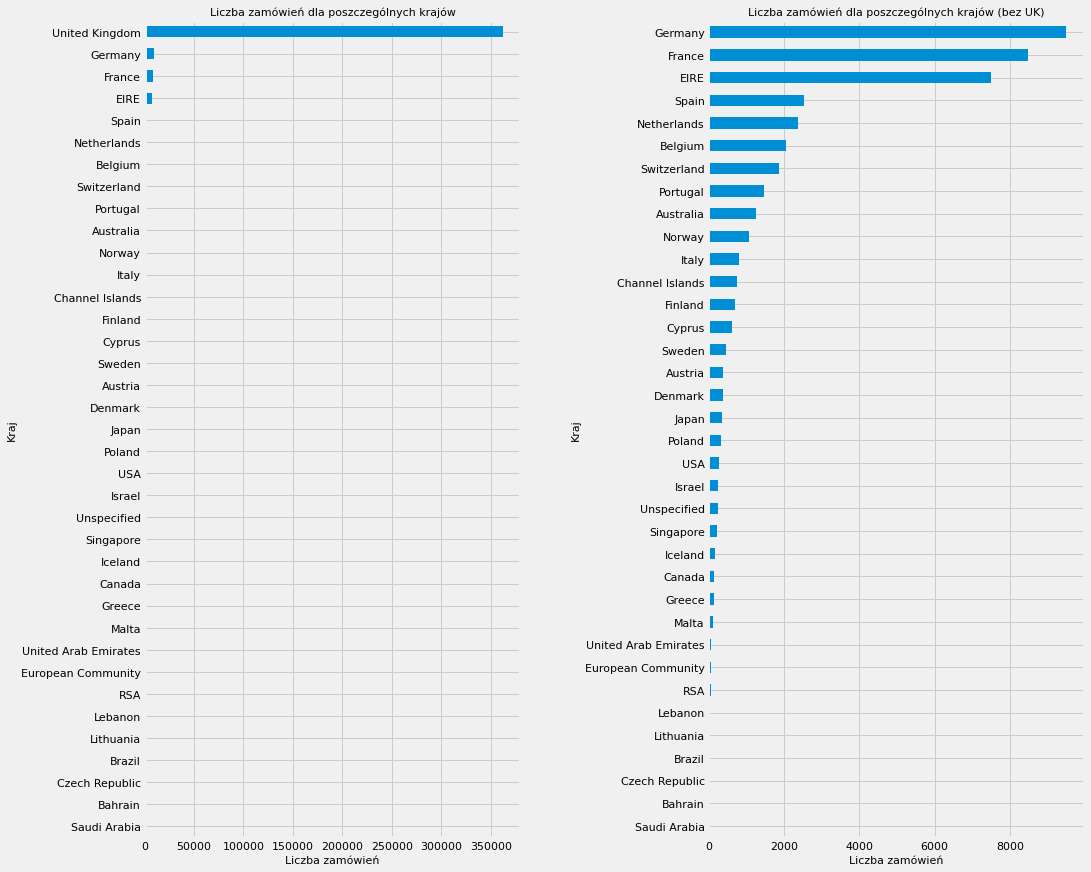

In [8]:
group_country_orders = df.groupby('Country')['InvoiceNo'].count().sort_values()

plt.figure(1 , figsize = (15 , 14))

# Wykres ilości klientów w zależnosci od kraju
plt.subplot(1 , 2 , 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_country_orders.plot(kind='barh', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Kraj', fontsize=11)
plt.title('Liczba zamówień dla poszczególnych krajów', fontsize=11)

# Wykres ilości klientów w zależnosci od kraju (bez UK)
del group_country_orders['United Kingdom']
plt.subplot(1 , 2 , 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_country_orders.plot(kind='barh', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Kraj', fontsize=11)
plt.title('Liczba zamówień dla poszczególnych krajów (bez UK)', fontsize=11)

plt.show()

In [9]:
df['InvoiceDateFormat']=pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

df.drop("InvoiceDayOfWeek", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceDayOfWeek', value=(df.InvoiceDateFormat.dt.day_name()))
df.drop("InvoiceDayOfWeekNumber", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceDayOfWeekNumber', value=(df.InvoiceDateFormat.dt.dayofweek))

df.drop("InvoiceMonth", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceMonth', value=(df.InvoiceDateFormat.dt.month_name()))

df.drop("InvoiceYear", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceYear', value=(df.InvoiceDateFormat.dt.year))

df.drop("InvoiceHour", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceHour', value=(df.InvoiceDateFormat.dt.hour))

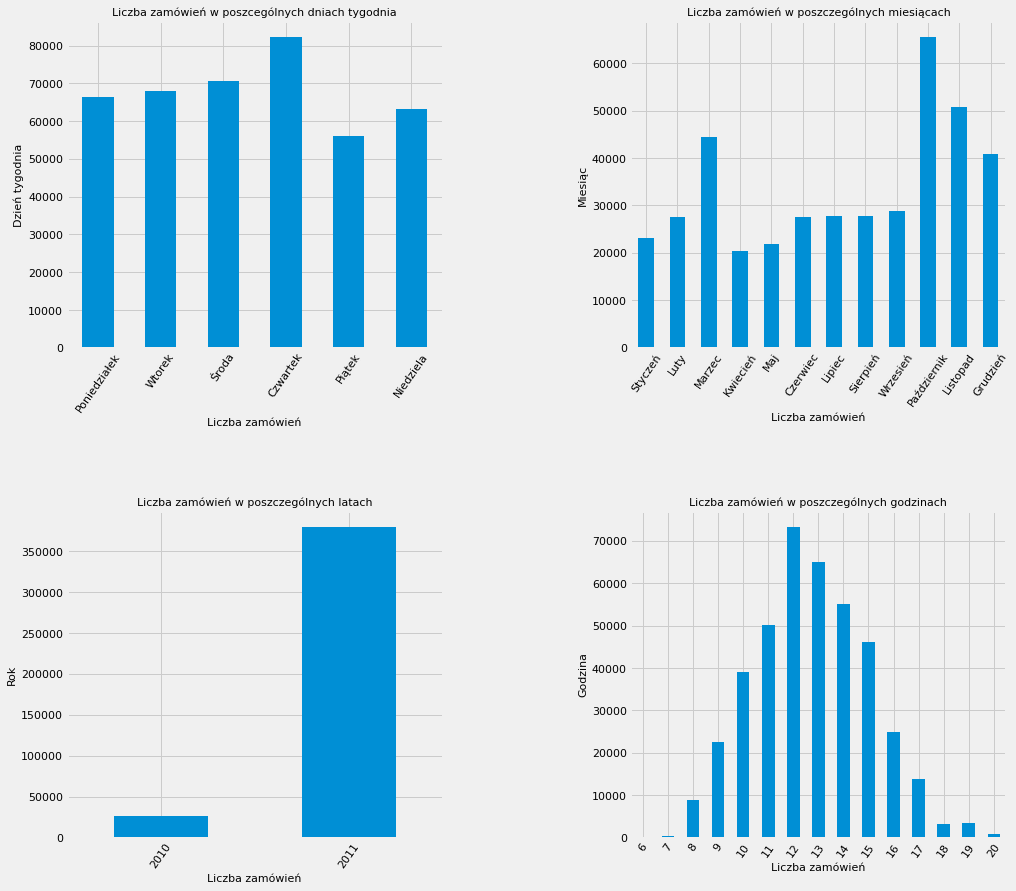

In [10]:
group_day_of_week_orders = df.groupby('InvoiceDayOfWeekNumber')['InvoiceNo'].count().sort_index()
group_month_orders = df.groupby('InvoiceMonth')['InvoiceNo'].count().sort_index()
group_year_orders = df.groupby('InvoiceYear')['InvoiceNo'].count().sort_index()
group_hour_orders = df.groupby('InvoiceHour')['InvoiceNo'].count().sort_index()

plt.figure(1 , figsize = (15 , 14))

# Wykres ilości zamówień w zależności od dnia tygodnia
plt.subplot(2 , 2 , 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_day_of_week_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Dzień tygodnia', fontsize=11)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =days_pl, rotation = 55)
plt.title('Liczba zamówień w poszcególnych dniach tygodnia', fontsize=11)

# Wykres ilości zamówień w zależności od miesiąca
plt.subplot(2 , 2 , 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_month_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Miesiąc', fontsize=11)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =months_pl, rotation = 55)
plt.title('Liczba zamówień w poszczególnych miesiącach', fontsize=11)

# Wykres ilości zamówień w zależności od roku
plt.subplot(2 , 2 , 3)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_year_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Rok', fontsize=11)
plt.xticks(rotation = 55)
plt.title('Liczba zamówień w poszczególnych latach', fontsize=11)

# Wykres ilości zamówień w zależności od godziny
plt.subplot(2 , 2 , 4)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_hour_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Godzina', fontsize=11)
plt.xticks(rotation = 55)
plt.title('Liczba zamówień w poszczególnych godzinach', fontsize=11)

plt.show()

In [11]:
df.drop("IsInvoiceCancelled", axis=1, errors='ignore', inplace = True)
df['IsInvoiceCancelled'] = df['InvoiceNo'].apply(lambda x: ('C' in x))

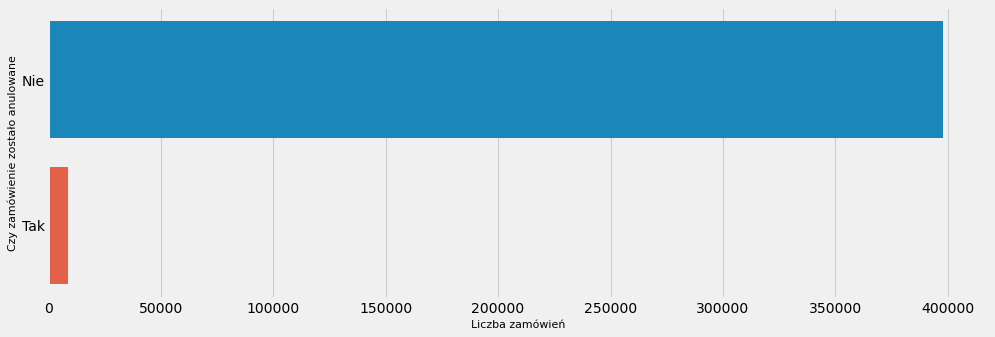

In [12]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'IsInvoiceCancelled' , data = df)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Czy zamówienie zostało anulowane', fontsize=11)
locs, labels = plt.yticks()
plt.yticks(ticks=locs, labels = ['Nie', 'Tak'])
plt.show()

In [13]:
df.drop("TotalPrice", axis=1, errors='ignore', inplace = True)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [14]:
revenue_df = df[['TotalPrice', 'InvoiceDateFormat']]
revenue_df['date'] = revenue_df['InvoiceDateFormat'].apply(lambda x: x.date())
revenue_by_date = revenue_df.groupby('date')['TotalPrice'].sum()

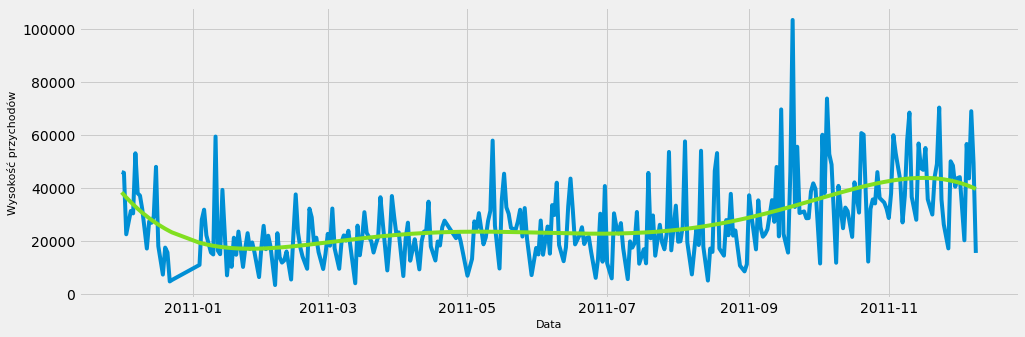

In [15]:
plt.figure(1 , figsize = (15 , 5))
z = np.polyfit(date2num(revenue_by_date.index), revenue_by_date.values, 5)
n = np.poly1d(z)(date2num(revenue_by_date.index))
sns.lineplot(revenue_by_date.index, revenue_by_date.values)
sns.lineplot(date2num(revenue_by_date.index), n, color="#81DF20")
plt.ylabel('Wysokość przychodów', fontsize=11)
plt.xlabel('Data', fontsize=11)
plt.show()

In [16]:
revenue_by_day = df.groupby('InvoiceDayOfWeekNumber')['TotalPrice'].sum().sort_index()

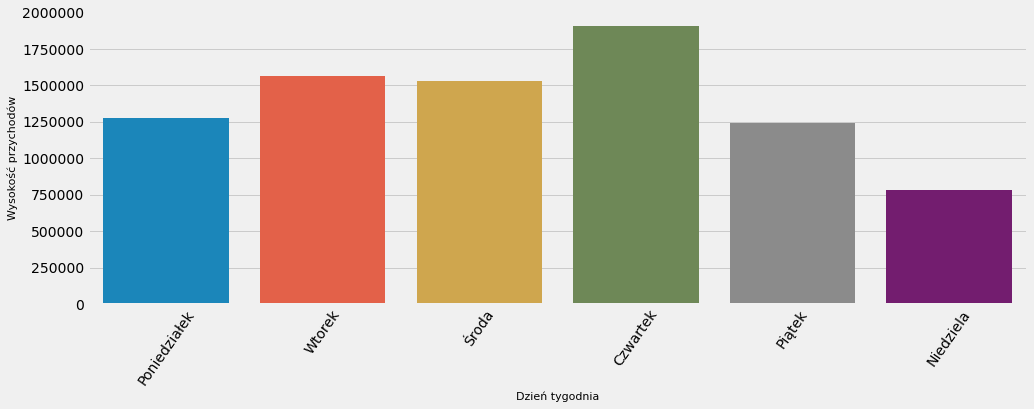

In [17]:
plt.figure(1 , figsize = (15 , 5))
sns.barplot(revenue_by_day.index, revenue_by_day.values)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =days_pl, rotation = 55)
plt.ylabel('Wysokość przychodów', fontsize=11, )
plt.xlabel('Dzień tygodnia', fontsize=11)
plt.ticklabel_format(useOffset = False, style = "plain", axis ='y')
plt.show()

<Figure size 1080x360 with 0 Axes>

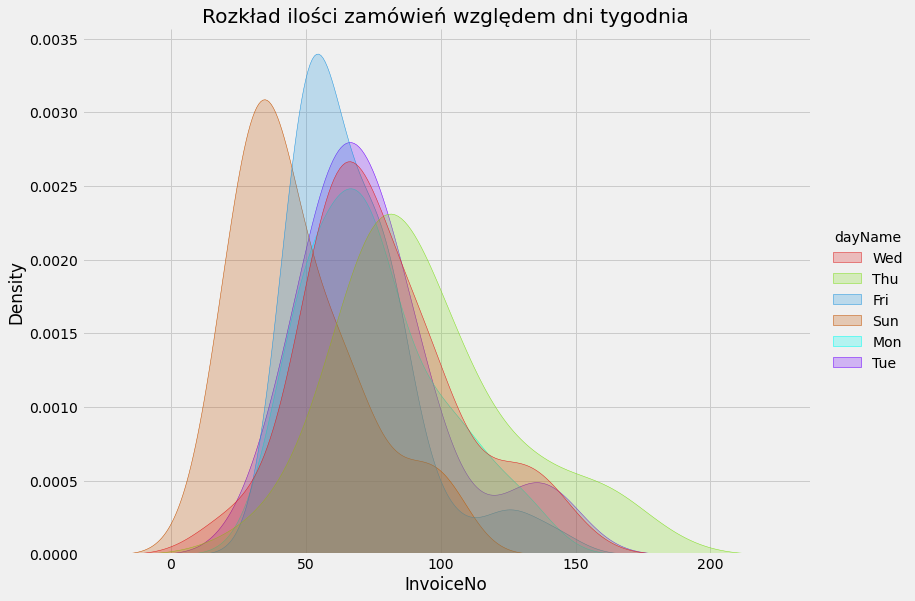

In [18]:
invoice_df = df[['InvoiceDateFormat', 'InvoiceNo']]
invoice_df['date'] = invoice_df['InvoiceDateFormat'].apply(lambda x: x.date())
invoice_count_by_day = invoice_df.groupby('date')['InvoiceNo'].nunique().reset_index()

invoice_count_by_day['dayName'] = invoice_count_by_day['date'].apply(lambda x: x.strftime("%a"))
sns.set_palette(sns.color_palette(colors))
plt.figure(1 , figsize = (15 , 5))
sns.displot(data=invoice_count_by_day, x="InvoiceNo", fill=True, hue = "dayName", kind = "kde", height=8.27, aspect=11.7/8.27)
plt.title('Rozkład ilości zamówień względem dni tygodnia')
plt.show()
plt.style.use('fivethirtyeight')

In [19]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Ilość zamówień'},
colorscale=[[0, '#ffd1d1'],
            [0.005, '#ff9c9c'], [0.02, '#ff9c9c'],
            [1, '#fa0000']],    
reversescale = False)
#_______________________
layout = dict(title='Ilość zamówień w poszczególnych krajach', geo = dict(showframe = True, projection={'type':'equirectangular'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
choromap.update_layout(
    autosize = False,
    width = 1200,
    height = 650
)
iplot(choromap, validate=False)

### Transformacja zmiennych

##### Tworzenie zbioru danych opisujących klienta

In [20]:
max_date = max(df['InvoiceDateFormat'])
df['DateDiff'] = max_date - df['InvoiceDateFormat']

customer_df = pd.DataFrame()
customer_df['CustomerID'] = df['CustomerID'].unique()

recency = df.groupby('CustomerID')['DateDiff'].min().dt.days.to_frame().rename(columns={'DateDiff' : 'Recency'})
frequency = df.groupby('CustomerID')['InvoiceNo'].count().to_frame().rename(columns={'InvoiceNo' : 'Frequency'})
monetary = df.groupby('CustomerID')['TotalPrice'].sum().to_frame().rename(columns={'TotalPrice' : 'Monetary'})
avg_order_value = df.groupby('CustomerID')['TotalPrice'].mean().to_frame().rename(columns={'TotalPrice' : 'AverageOrderValue'})
avg_quantity = df.groupby('CustomerID')['Quantity'].mean().to_frame().rename(columns={'Quantity' : 'AverageQuantity'})

customer_df = customer_df.merge(recency, how="inner", on="CustomerID")
customer_df = customer_df.merge(frequency, how="inner", on="CustomerID")
customer_df = customer_df.merge(monetary, how="inner", on="CustomerID")
customer_df = customer_df.merge(avg_order_value, how="inner", on="CustomerID")
customer_df = customer_df.merge(avg_quantity, how="inner", on="CustomerID")



Lista zmiennych opisujących klienta:
- ***Recency*** - liczba dni od ostatniego zamówienia
- ***Frequency*** - ilość zamówień
- ***Monetary*** - łączna kwota zamówień
- ***AverageOrderValue*** - średnia wartość zamówienia
- ***AverageQuantity*** - średnia ilość produktów w zamówieniu

##### Badanie obserwacji odstających

In [21]:
def boxplotColumns(dataframe, title):
    columns = dataframe.columns[1:]
    r = c = 0
    figure, ax = plt.subplots(3, 2, figsize = (15, 9))
    
    for n, i in enumerate(columns):
        sns.boxplot(x = i, data = dataframe, ax = ax[r, c])
        c += 1
        if (n + 1) % 2 == 0:
            r += 1
            c = 0
    ax[r, c].axis("off")
    plt.suptitle(title)
    figure.tight_layout()
    plt.show()

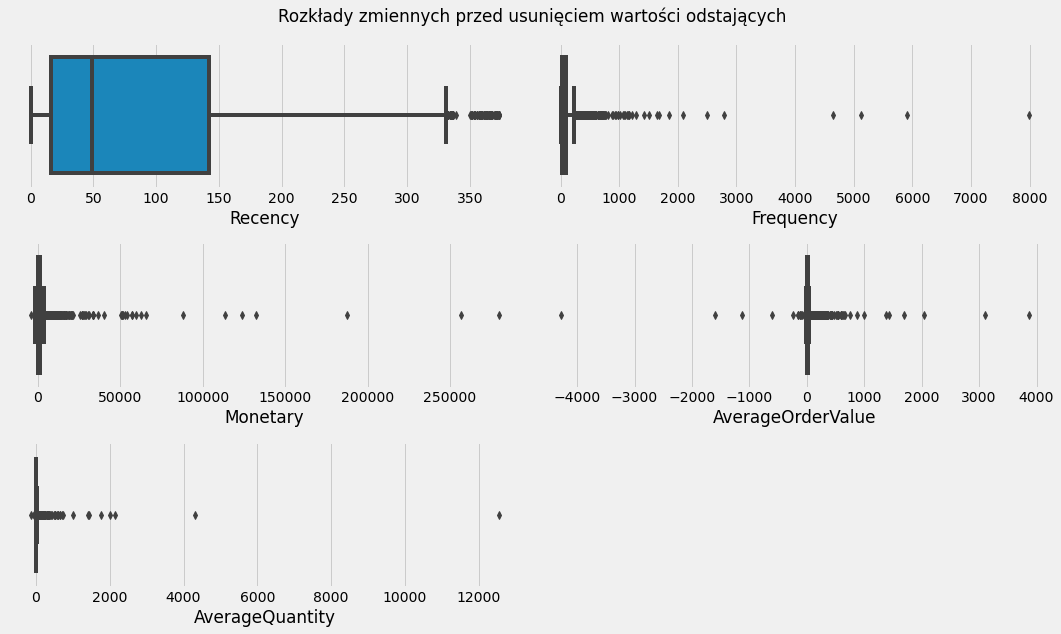

In [22]:
boxplotColumns(customer_df, 'Rozkłady zmiennych przed usunięciem wartości odstających')

Na podstawie powyższych wykresów pudełkowych widać, że zmienne Monetary, Frequency, AverageQuantity oraz AverageOrderValue mają wartości odstające. Ponieważ algorytmy grupowania, takie jak K-Means, są podatne na wartości odstające, będziemy je usuwać, ograniczając je do 95% kwantyla.

Dodatkowo usunięte zostaną obserwacje z wartościami AverageQuantity oraz AverageOrderValue < 0. Wynika to z faktu, że klient zakupił towar przed rozpoczęciem zbierania danych, a zwrócił w trakcie zbierania danych, przez co wartości tych zmiennych są ujemne, a same dane są statystycznie nieprzydatne.

In [23]:
# Monetary outliers

upper_threshold = 0.95
upper_threshold_val = customer_df['Monetary'].quantile(upper_threshold)
customer_df['Monetary'][customer_df['Monetary'] > upper_threshold_val] = upper_threshold_val
lower_threshold = 1 - upper_threshold
lower_threshold_val = customer_df['Monetary'].quantile(lower_threshold)
customer_df['Monetary'][customer_df['Monetary'] < lower_threshold_val] = lower_threshold_val

In [24]:
# Frequency outliers

upper_threshold = 0.95
upper_threshold_val = customer_df['Frequency'].quantile(upper_threshold)
customer_df['Frequency'][customer_df['Frequency'] > upper_threshold_val] = upper_threshold_val

In [25]:
# AverageOrderValue outliers

customer_df = customer_df.drop(customer_df[customer_df['AverageOrderValue'] < 0].index)

upper_threshold = 0.95
upper_threshold_val = customer_df['AverageOrderValue'].quantile(upper_threshold)
customer_df['AverageOrderValue'][customer_df['AverageOrderValue'] > upper_threshold_val] = upper_threshold_val


In [26]:
# AverageQuantity outliers

customer_df = customer_df.drop(customer_df[customer_df['AverageQuantity'] < 0].index)

upper_threshold = 0.95
upper_threshold_val = customer_df['AverageQuantity'].quantile(upper_threshold)
customer_df['AverageQuantity'][customer_df['AverageQuantity'] > upper_threshold_val] = upper_threshold_val

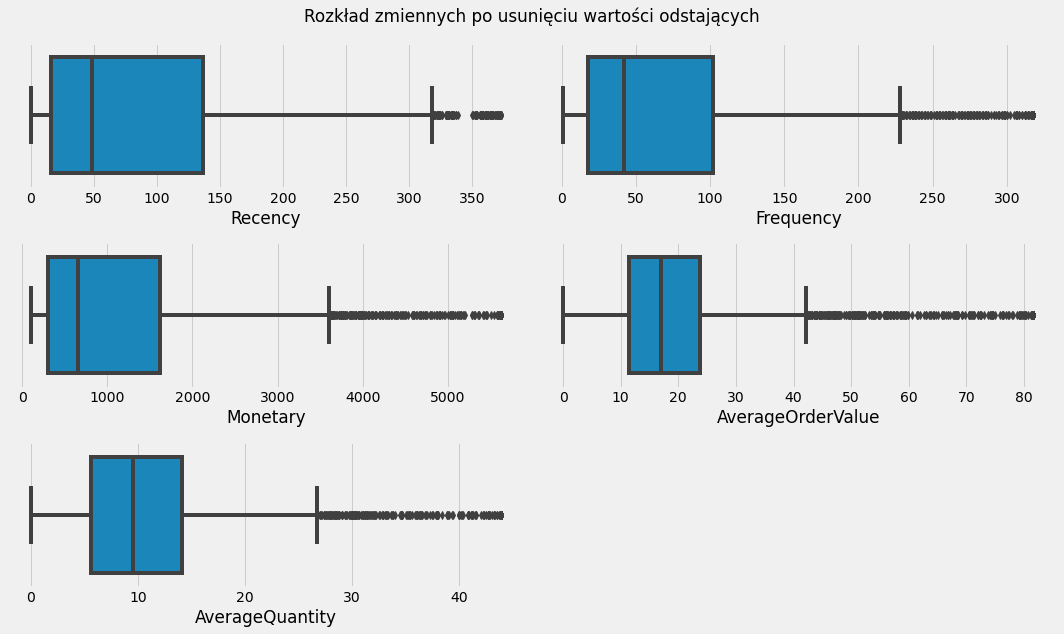

In [27]:
boxplotColumns(customer_df, 'Rozkład zmiennych po usunięciu wartości odstających')

##### Skalowanie i normalizacja

Skalowanie poszczególnych zmiennych realizowane jest według poniższych wzorów:

*X_std = ( X - X.min( axis=0 ) ) / ( X.max( axis=0 ) - X.min( axis=0 ) )* <br>
*X_scaled = X_std * ( max - min ) + min*

In [28]:
preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("pca", PCA(random_state=42)),
        ]
    )

In [29]:
customer_df = customer_df.drop('CustomerID',axis=1)
customer_df_scaled = pd.DataFrame(preprocessor.fit_transform(customer_df), columns=customer_df.columns)

In [30]:
# Badanie skośności zmiennych zeskalowanych
customer_df_skewness = customer_df_scaled.skew(axis=0)
display(customer_df_skewness)

Recency              1.062235
Frequency            1.776761
Monetary             0.651962
AverageOrderValue   -0.069218
AverageQuantity      1.275576
dtype: float64

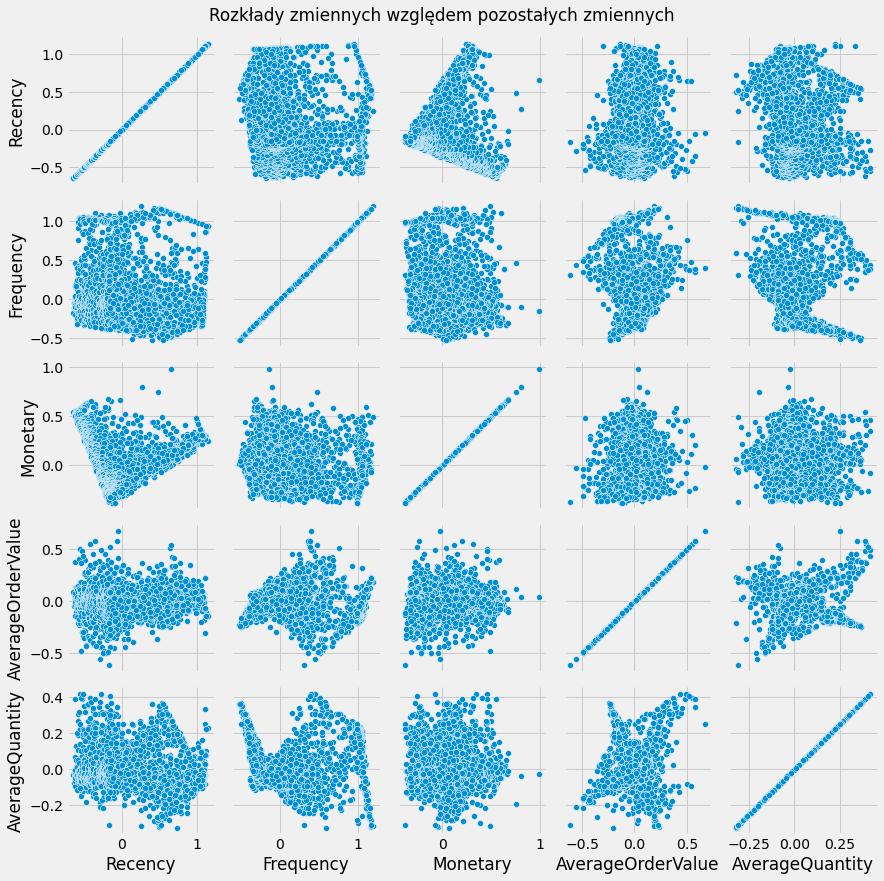

In [31]:
g = sns.PairGrid(customer_df_scaled)
g.map(sns.scatterplot)
g.fig.suptitle('Rozkłady zmiennych względem pozostałych zmiennych')
g.fig.tight_layout()

### Klasteryzacja

Tworzenie zbiorów danych z wybraną parą zmiennych

In [32]:
# Selekcja zmiennych, na podstawie których wykonana zostanie klasteryzacja

#1
variable_pair = ['Recency', 'Monetary']
customer_df_for_clustering_scaled = customer_df_scaled[[variable_pair[0], variable_pair[1]]]
customer_df_for_clustering = customer_df[[variable_pair[0], variable_pair[1]]]

#2
# variable_pair = ['Frequency', 'Recency']
# customer_df_for_clustering_scaled = customer_df_scaled[[variable_pair[0], variable_pair[1]]]
# customer_df_for_clustering = customer_df[[variable_pair[0], variable_pair[1]]]

#3
# variable_pair = ['AverageOrderValue', 'AverageQuantity']
# customer_df_for_clustering_scaled = customer_df_scaled[[variable_pair[0], variable_pair[1]]]
# customer_df_for_clustering = customer_df[[variable_pair[0], variable_pair[1]]]

<br>
Wyznaczanie optymalnej liczby klastrów na podstawie współczynnika Silhouette'a

In [33]:
def findBestN(dataframe):
    silhouette_values = pd.DataFrame( columns=['ClusterCount', 'SilhouetteValue'])
    for n in range(3,15):
        kmeans = KMeans(n_clusters = n, n_init=20, random_state=22, max_iter = 50 )
        kmeans.fit(dataframe)
        clusters = kmeans.predict(dataframe)
        silhouette_avg = silhouette_score(dataframe, clusters)
        silhouette_values = silhouette_values.append({'ClusterCount': n, 'SilhouetteValue': silhouette_avg}, ignore_index = True)
    return silhouette_values

In [34]:
# Wyznaczenie wartości współczynnika Silhouette'a

silhouette_values = findBestN(customer_df_for_clustering_scaled)

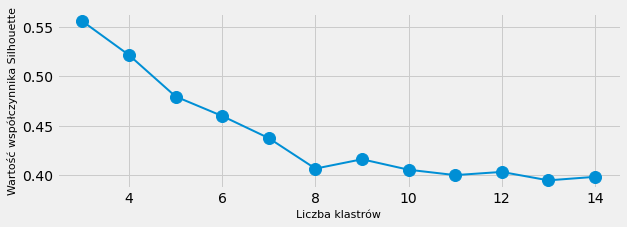

In [35]:
# Wykres wartości wspołczynnika Silhouette'a dla poszczególnej liczby klastrów

plt.figure(1 , figsize = (9 , 3) )
plt.plot(silhouette_values['ClusterCount'], silhouette_values['SilhouetteValue'], marker='o', linestyle='-', linewidth=2, markersize=12)
plt.ylabel('Wartość współczynnika Silhouette', fontsize=11, )
plt.xlabel('Liczba klastrów', fontsize=11)
plt.show()

Segmentacja klientów za pomocą algorytmu K-Means (wykorzysując zeskalowane wartości zmiennych)

In [36]:
# Klasteryzacja metodą K-means

best_cluster_count = 3
algorithm = (KMeans(n_clusters = best_cluster_count ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 31  , algorithm='elkan') )
algorithm.fit(customer_df_for_clustering_scaled)

centroids = algorithm.cluster_centers_
customer_df_for_clustering_scaled['cluster'] = algorithm.labels_
customer_df_for_clustering['cluster'] = algorithm.labels_

Wyświetlenie rozkładu wybranej pary zmiennych w zależności od klastrów

<Figure size 648x216 with 0 Axes>

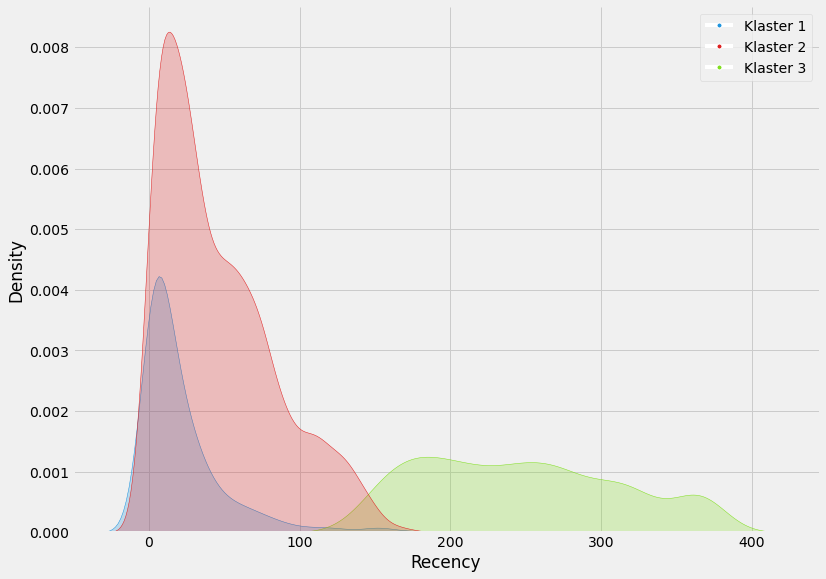

In [43]:
sns.set_palette(sns.color_palette(colors))
plt.figure(1 , figsize = (9 , 3) )
sns.displot(data=customer_df_for_clustering, x=variable_pair[0], fill=True, hue = 'cluster' ,kind = "kde", height=8.27, aspect=11.7/8.27, palette=colors[:best_cluster_count], legend=False)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Klaster {}'.format(i+1), 
markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(customer_df_for_clustering['c'].unique())]
plt.legend(handles=legend_elements, loc='best')
plt.show()

<Figure size 648x216 with 0 Axes>

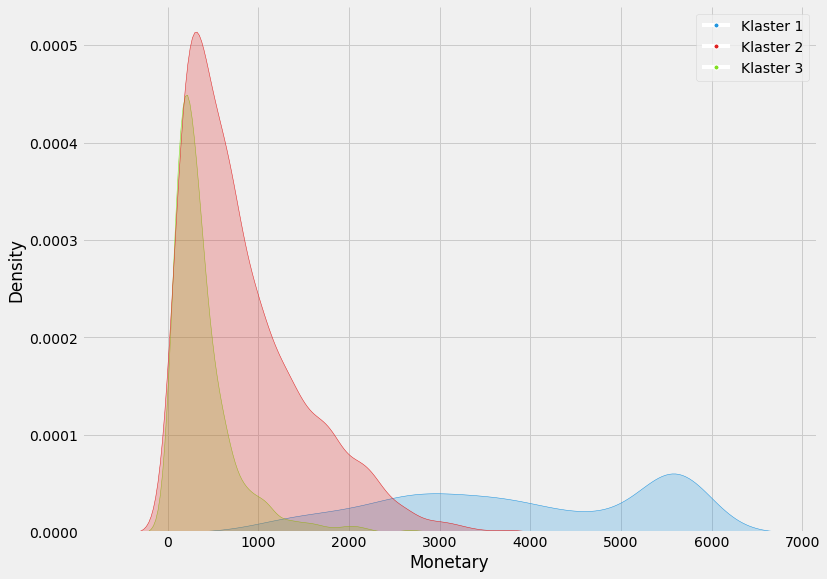

In [44]:
plt.figure(1 , figsize = (9 , 3) )
sns.displot(data=customer_df_for_clustering, x=variable_pair[1], fill=True, hue = 'cluster' ,kind = "kde", height=8.27, aspect=11.7/8.27, palette=colors[:best_cluster_count], legend=False)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Klaster {}'.format(i+1), 
markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(customer_df_for_clustering['c'].unique())]
plt.legend(handles=legend_elements, loc='best')
plt.show()

plt.style.use('fivethirtyeight')

Wyświetlenie wykresów podziału na klastry dla wartości zeskalowanych oraz warości realnych

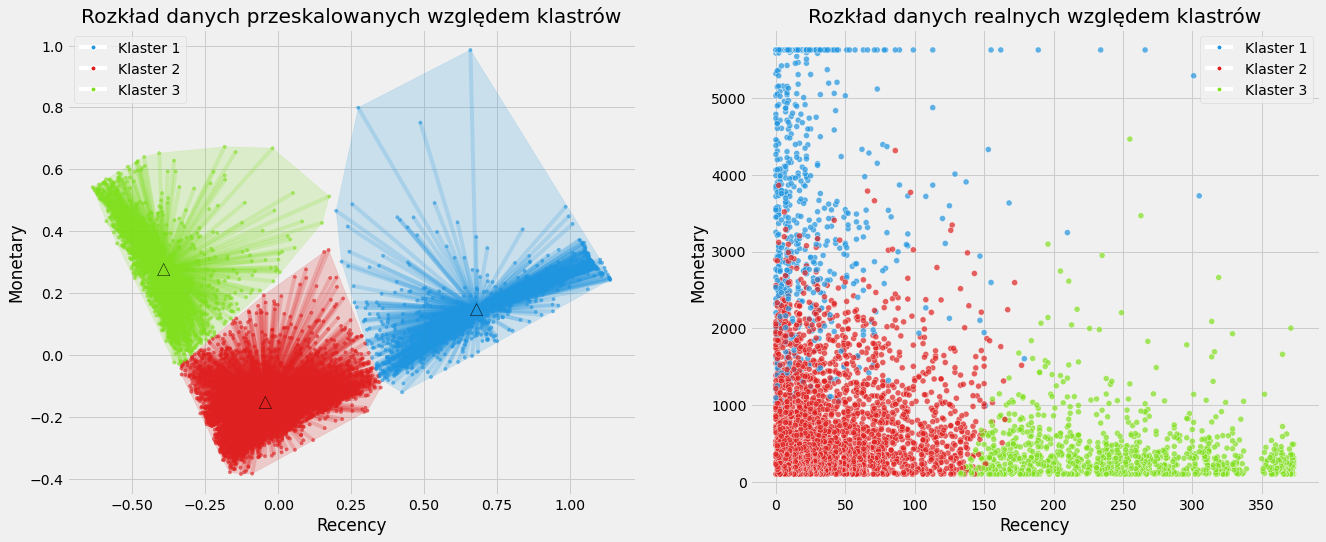

In [38]:
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

# Mapowanie kolorów
customer_df_for_clustering_scaled['c'] = customer_df_for_clustering_scaled.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6], 7:colors[7], 8:colors[8], 9:colors[9], \
    10:colors[10], 11:colors[11]})
customer_df_for_clustering['c'] = customer_df_for_clustering.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6], 7:colors[7], 8:colors[8], 9:colors[9], \
    10:colors[10], 11:colors[11]})

plt.figure(figsize=[20,8])

# ---------------------
# Przesklowane wartości
plt.subplot(1, 2, 1)
# Punkty
plt.scatter(customer_df_for_clustering_scaled[variable_pair[0]], customer_df_for_clustering_scaled[variable_pair[1]], c=customer_df_for_clustering_scaled.c, alpha = 0.6, s=10)

# Centra klastrów
plt.scatter(cen_x, cen_y, marker='^', c=colors[:len(customer_df_for_clustering_scaled['c'].unique())], s=150, edgecolors='black', zorder=100)

# Linie
for idx, val in customer_df_for_clustering_scaled.iterrows():
    x = [val[variable_pair[0]], cen_x[int(val['cluster'])],]
    y = [val[variable_pair[1]], cen_y[int(val['cluster'])]]
    plt.plot(x, y, c=val.c, alpha=0.2)
# Legenda
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Klaster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(customer_df_for_clustering_scaled['c'].unique())]
plt.legend(handles=legend_elements, loc='best')
plt.xlabel(variable_pair[0])
plt.ylabel(variable_pair[1])
plt.title('Rozkład danych przeskalowanych względem klastrów')
# Obszar klastra
for i in customer_df_for_clustering_scaled.cluster.unique():
    points = customer_df_for_clustering_scaled[customer_df_for_clustering_scaled.cluster == i][[variable_pair[0], variable_pair[1]]].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    plt.fill(x_hull, y_hull, alpha=0.18, c=colors[int(i)])

# ---------------------
# Prawdziwe wartości
plt.subplot(1, 2, 2)
sns.scatterplot(data=customer_df_for_clustering,x=variable_pair[0],y=variable_pair[1],  c=customer_df_for_clustering.c, alpha=0.7)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Klaster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(customer_df_for_clustering['c'].unique())]
plt.legend(handles=legend_elements, loc='best')
plt.title('Rozkład danych realnych względem klastrów')
plt.show()